In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns

In [16]:
plt.rcParams["figure.figsize"] = (9,4)

In [3]:
df = pd.read_csv(r"C:\Users\NIHARIKA PANDA\Downloads\ec2_cpu_utilization_24ae8d.csv")
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [5]:
anomalies_ts = [
    "2014-02-26 22:05:00",
    "2014-02-27 17:15:00" ]

In [20]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value,is_anomaly,z_score,baseline
0,2014-02-14 14:30:00,0.132,1,-0.6745,-1
1,2014-02-14 14:35:00,0.134,1,0.0000,-1
2,2014-02-14 14:40:00,0.134,1,0.0000,-1
3,2014-02-14 14:45:00,0.134,1,0.0000,-1
4,2014-02-14 14:50:00,0.134,1,0.0000,-1


In [21]:
# add an anomaly label (1 -> an inlier, -1 -> an outlier !)

df['is_anomaly'] = 1         
for each in anomalies_ts:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1

df.head()

,timestamp,value,is_anomaly,z_score,baseline
0,2014-02-14 14:30:00,0.132,1,-0.6745,-1
1,2014-02-14 14:35:00,0.134,1,0.0000,-1
2,2014-02-14 14:40:00,0.134,1,0.0000,-1
3,2014-02-14 14:45:00,0.134,1,0.0000,-1
4,2014-02-14 14:50:00,0.134,1,0.0000,-1


In [22]:
anomaly_df = df.loc[df['is_anomaly']==-1]
inliner_df = df.loc[df['is_anomaly']==1]

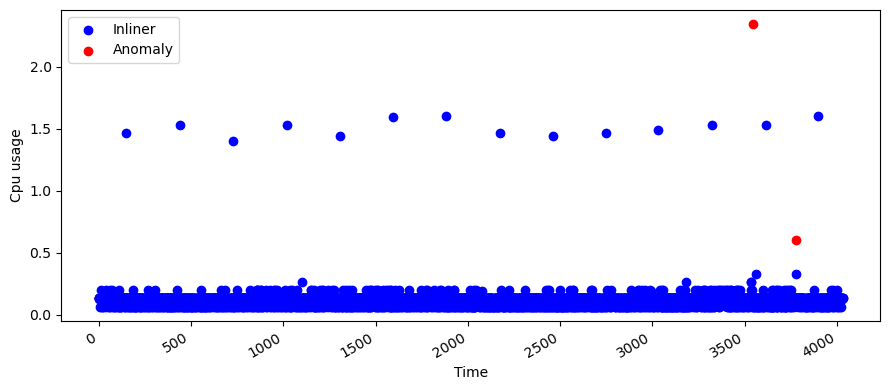

In [35]:
fig, ax = plt.subplots()

ax.scatter(inliner_df.index, inliner_df['value'], color ='b', label = 'Inliner')
ax.scatter(anomaly_df.index, anomaly_df['value'], color ='r', label = 'Anomaly')

ax.set_xlabel('Time')
ax.set_ylabel('Cpu usage')
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()



### 1. Basline : Mean Absolute Deviation

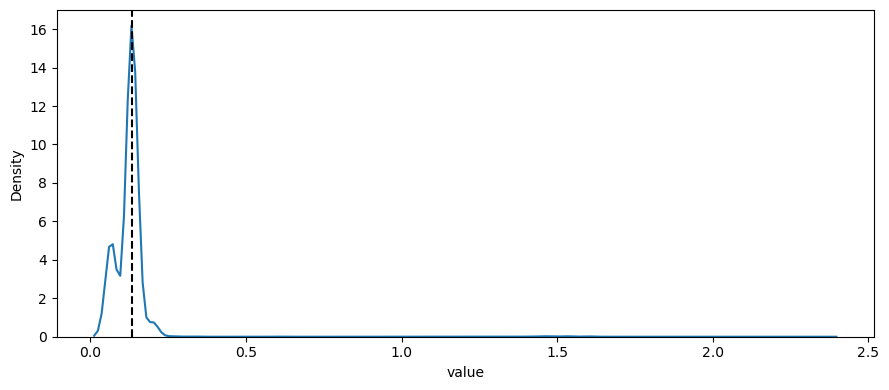

In [23]:
sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls = '--')
plt.tight_layout()

In [11]:
from scipy.stats import median_abs_deviation

In [12]:
mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print(mad)
print(median)

def compute_robust_zscore(x):
    return 0.6745 * (x-median)/mad

0.0020000000000000018
0.134


In [24]:
# commpute the robust z-score for each sample

df['z_score'] = df['value'].apply(compute_robust_zscore)

df.head()

,timestamp,value,is_anomaly,z_score,baseline
0,2014-02-14 14:30:00,0.132,1,-0.6745,-1
1,2014-02-14 14:35:00,0.134,1,0.0000,-1
2,2014-02-14 14:40:00,0.134,1,0.0000,-1
3,2014-02-14 14:45:00,0.134,1,0.0000,-1
4,2014-02-14 14:50:00,0.134,1,0.0000,-1


In [14]:
# determine if it is a anomaly (use threshold of 3.5)

df['baseline'] = 1

df.loc[df['value'] >= 3.5, 'baseline'] = -1
df.loc[df['value'] <= 3.5, 'baseline'] = -1

#### Evaluation

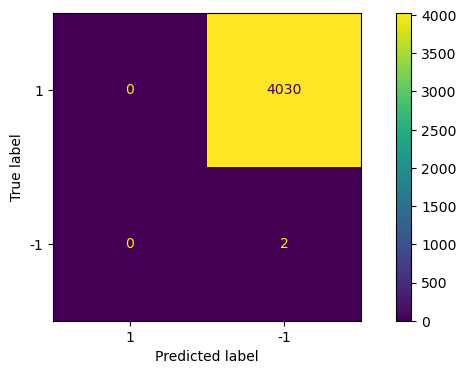

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot()

plt.grid(False)
# plt.tight_layout()

MAD was absolutely was not a good model for the outlier detection, as the data is more median centric. MAD works more accurately for normally distrubuted data. Here, the confusion matrix clearly shows how this model incorrectly label normal data as a outlier.Any value that is slightly deviated from median, is flagged as an outlier.

### 2. Isolation Forest

In [27]:
from sklearn.ensemble import IsolationForest

In [28]:
# split the data (keep one anomaly in the test set)
train = df[:3550]
test = df[3550:]

In [29]:
contamination = 1/len(train)

iso_forest = IsolationForest(contamination=contamination, random_state=42)

X_train = train['value'].values.reshape(-1,1)

iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

In [30]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

#### Evaluation

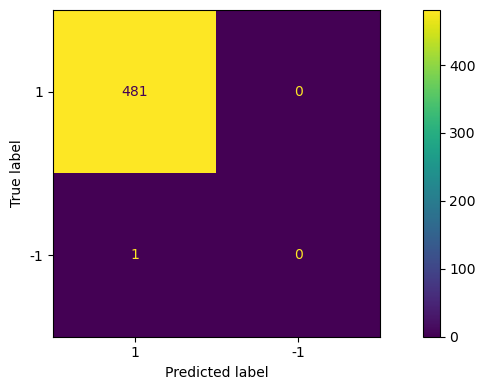

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

Here, in fact it did not manage to identify the anomaly. It predicted evrything is an inlier

### 3. Local Outlier Factor

In [32]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [33]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

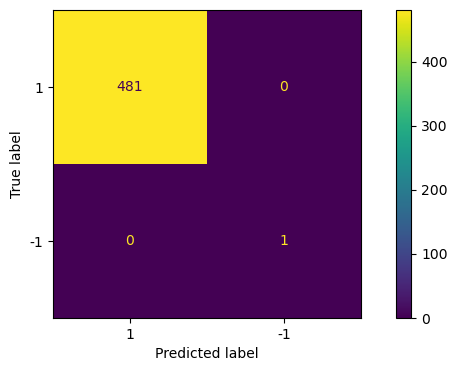

In [34]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

LOF is able to identify the incoming anomaly in the dataset. Everything that was predicted as an inliner is actually an inlier ans one anomlay was labelled correct !